# 육지(제주도)를 관통하는 항로 발생 -> 선박들의 항로 시각화

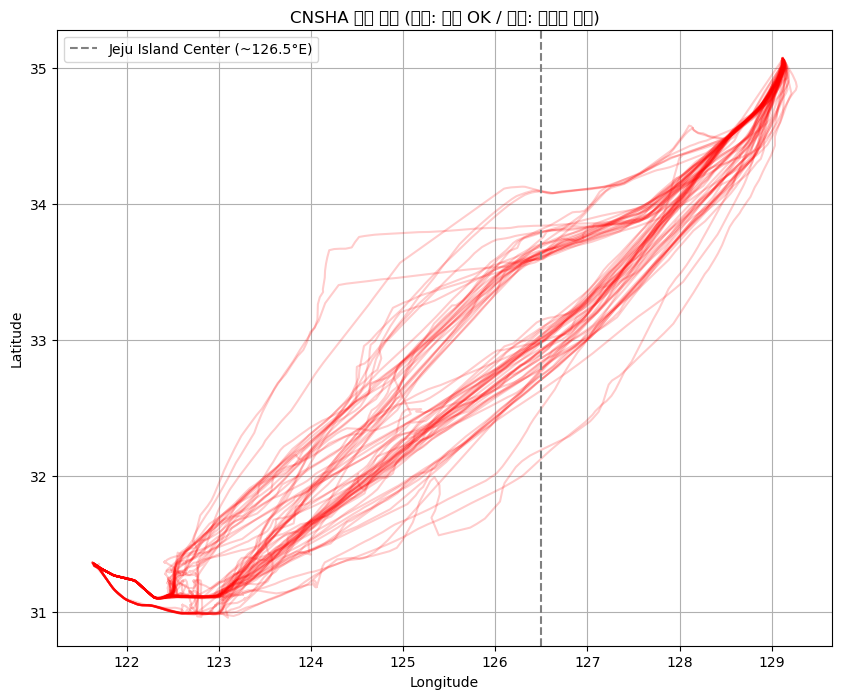

In [49]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# CNSHA 항구로 가는 원본 선박 경로 시각화해서, 제주도 기준 동쪽/서쪽 선박을 판단해보기 위한 준비
plt.figure(figsize=(10, 8))

# 제주도 중심 경도 대략적으로 126.5로 설정
jeju_lon = 126.5

# 선박 ID별로 선박 경로를 그림
filtered_routes = []
excluded_routes = []

for (vsl_id, _), group in port_df.groupby(["VSL_ID", "PORT_NAME"]):
    coords = group[["LAT", "LON"]].values
    if len(coords) < num_interp_points:
        continue
    
    # 경로가 제주도 서쪽(126 이하) 또는 동쪽(127 이상)만 통과한 경우 필터링
    min_lon, max_lon = coords[:, 1].min(), coords[:, 1].max()
    
    if max_lon < jeju_lon or min_lon > jeju_lon:  # 제주도 중심 경도 기준 완전히 좌우로 통과
        filtered_routes.append(coords)
        plt.plot(coords[:, 1], coords[:, 0], color='blue', alpha=0.4)
    else:
        excluded_routes.append(coords)
        plt.plot(coords[:, 1], coords[:, 0], color='red', alpha=0.2)  # 육지를 통과하는 경로는 붉은색

# 시각화
plt.axvline(jeju_lon, color='gray', linestyle='--', label='Jeju Island Center (~126.5°E)')
plt.title("CNSHA 선박 경로 (파랑: 통과 OK / 빨강: 제주도 관통)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()

# 필요한 라이브러리 import 

In [1]:
import pandas as pd
import numpy as np
import folium
import random
import json
from shapely.geometry import Point, shape
from shapely.prepared import prep
from scipy.interpolate import interp1d
import os

# 사전 세팅: 전역 변수 (필요 시 수정 가능)

In [2]:
# 함수에서 사용할 것이라 필요하면 여기서 수정하고 함수 다시 실행
num_interp_points = 100 
num_particles = 30
num_iterations = 50
w, c1, c2 = 0.5, 1.5, 1.5

# GeoJSON 기반 육지 경계 준비 (한 번만 실행!!!!!!)

In [3]:
with open("./dataset/custom.geo.10.json", "r", encoding="utf-8") as f:
    geojson_data = json.load(f)

land_polygons = [shape(f["geometry"]) for f in geojson_data["features"]
                 if f["geometry"]["type"] in ["Polygon", "MultiPolygon"]]

land_union = land_polygons[0]
for poly in land_polygons[1:]:
    land_union = land_union.union(poly)

# prepared_land_union = prep(land_union)

prepared_land_union = prep(land_union.buffer(0.01)) # --> 제주도 지나갈 때 사용하면 유용할 듯
# prepared_land_union -> 육지 근처로 가면 패널티 주는 코드
# 0.01 -> 육지로 부터 1 ~ 1.15km
# 0.02 -> 육지로 부터 2 ~ 3km
# 0.1 -> 육지로 부터 10km'
# 0.05이상은 비추, 품질이 떨어질 수 있음 

# 대표 항로 생성 함수

In [4]:
def generate_representative_route(df, port_name, output_dir="."):
    # 전체 데이터프레임(df)에서 PORT_NAME이 해당 항구인 행만 추출
    # 선박별 항로를 시간순으로 정렬
    df_port = df[df["PORT_NAME"] == port_name].copy()
    df_port = df_port.sort_values(by=["VSL_ID", "TIMESTAMP"]) # 특정 항구 데이터 필터링

    vessel_routes = []
    # 선박별 항로 좌표 추출 및 보간
    # 모든 항로를 동일한 길이 num_interp_points(100)로 보간해줌 그래야 나중에 입자(Particle)로 사용 가능
    for _, group in df_port.groupby("VSL_ID"):
        coords = group[["LAT", "LON"]].values
        if len(coords) >= num_interp_points:
            n_points = len(coords)
            original_idx = np.linspace(0, 1, n_points)
            target_idx = np.linspace(0, 1, num_interp_points)
            lat_interp = interp1d(original_idx, coords[:, 0], kind="linear")
            lon_interp = interp1d(original_idx, coords[:, 1], kind="linear")
            interpolated_coords = np.stack([lat_interp(target_idx), lon_interp(target_idx)], axis=1)
            vessel_routes.append(interpolated_coords)
    if len(vessel_routes) < 2:
        print(f"⚠️ 항구 {port_name}: 유효한 경로가 부족합니다.")
        return

    # PSO 초기화 
    # -> 모든 선박 항로를 입자로 처리하기 위해 벡터로 치환
    # -> 각 입자별 초기 위치와 속도 설정
    # -> 최적 위치(best), 전역 최적(global_best)도 초기화
    routes_array = np.array(vessel_routes)
    particles = [route.flatten() for route in random.sample(list(routes_array), min(num_particles, len(routes_array)))]
    velocities = [np.zeros_like(p) for p in particles]
    personal_best = particles.copy()
    personal_best_scores = [float('inf')] * len(particles)
    global_best = None
    global_best_score = float('inf')

    # Fitness 함수 정의 (중요!!!!!!)
    # -> 한 입자(입력한 후보 항로에 대해 평가)
    # -> 항로가 육지 위를 지나면 큰 페널티 부여 + 다른 실제 항로들과 얼마나 비슷한지 평균 거리 계산
    # -> 육지를 피해가면서도 다른 항로들과 유사한 항로를 찾는 구조
    def fitness(candidate_flat):
        candidate = candidate_flat.reshape((num_interp_points, 2))
        penalty = sum(prepared_land_union.contains(Point(lon, lat)) for lat, lon in candidate) * 500
        # 코드상으로는 Point(lon, lat)이 맞음, candidat는 lat, lon이라서 바꾼 듯 ! 코드 수정 필요 Xx
        distances = [np.linalg.norm(candidate - r) for r in routes_array]
        return np.mean(distances) + penalty

    # PSO 최적화 반복
    # -> 각 입자에 대해 함수 fitness 계산
    # -> 자기 자신보다 더 좋은 위치가 있으면 업데이트
    # -> 전체에서 가장 좋은 경로를 계속 갱신
    for _ in range(num_iterations):
        for i in range(len(particles)):
            score = fitness(particles[i])
            if score < personal_best_scores[i]:
                personal_best_scores[i] = score
                personal_best[i] = particles[i].copy()
            if score < global_best_score:
                global_best_score = score
                global_best = particles[i].copy()
        for i in range(len(particles)):
            r1, r2 = np.random.rand(), np.random.rand()
            velocities[i] += (
                w * velocities[i] +
                c1 * r1 * (personal_best[i] - particles[i]) +
                c2 * r2 * (global_best - particles[i])
            )
            particles[i] += velocities[i]

    final_route = global_best.reshape((num_interp_points, 2))

    # 지도 시각화 및 저장
    m = folium.Map(location=final_route[0].tolist(), zoom_start=6)
    folium.PolyLine(locations=final_route.tolist(), color='blue', weight=3).add_to(m)
    folium.Marker(location=final_route[0].tolist(), popup="Start", icon=folium.Icon(color="green")).add_to(m)
    folium.Marker(location=final_route[-1].tolist(), popup="End", icon=folium.Icon(color="red")).add_to(m)
    
    # 디렉터리 생성
    output_dir = "pso"
    os.makedirs(output_dir, exist_ok=True)
    
    # 저장
    final_route_df = pd.DataFrame(final_route, columns=["LAT", "LON"])
    csv_path = f"{output_dir}/{port_name}_route.csv"
    final_route_df.to_csv(csv_path, index=False)
    print(f"✅ {port_name} 대표항로 CSV 저장 완료: {csv_path}")

In [22]:
df = pd.read_csv("./dataset/must_use_final.csv")
generate_representative_route(df, port_name="JPHKT")

⚠️ 항구 JPHKT: 유효한 경로가 부족합니다.


# 저장한 CSV 파일 folium으로 확인

In [15]:
import folium

# CSV 읽기
df = pd.read_csv("./pso/KRYOS_route.csv")

# 지도 생성
m = folium.Map(location=[df.iloc[0]["LAT"], df.iloc[0]["LON"]], zoom_start=6)

# 경로 추가
folium.PolyLine(locations=df[["LAT", "LON"]].values.tolist(), color="blue", weight=3).add_to(m)

# 시작/종료 마커
folium.Marker(location=df.iloc[0][["LAT", "LON"]].values.tolist(), popup="Start", icon=folium.Icon(color="green")).add_to(m)
folium.Marker(location=df.iloc[-1][["LAT", "LON"]].values.tolist(), popup="End", icon=folium.Icon(color="red")).add_to(m)

# 지도 저장 or 바로 보기
# m.save("check_route.html")
m